# EDA: Stable Diffusion Image → Prompt

This notebook is an **Exploratory Data Analysis (EDA)** of three publicly available datasets:

- [Stable Diffusion Image→Prompt Competition](https://www.kaggle.com/competitions/stable-diffusion-image-to-prompts/data)  
- [MS COCO 2017 Annotations & Images](https://images.cocodataset.org/annotations/annotations_trainval2017.zip),  
  [Train 2017 Images](https://images.cocodataset.org/zips/train2017.zip),  
  [Val 2017 Images](https://images.cocodataset.org/zips/val2017.zip)  
- [Flickr-30k Captions](https://www.kaggle.com/datasets/hsankesara/flickr-image-dataset/data?select=flickr30k_captions.csv)


You can find the full setup instructions and data‐download steps in the project’s **README** on GitHub:  
[Springboard Capstone – Step 2 README](https://github.com/stephenebert/Springboard/tree/main/Capstone/step2/README.md).

In this EDA, we’ll compare how people craft text prompts for a state-of-the-art image-generation model (Stable Diffusion) against two classic caption corpora (MS COCO 2017 & Flickr-30k), with the goal of uncovering differences in:

- **Length & complexity** (How verbose are prompts vs. captions?)  
- **Vocabulary & style** (Do prompts use richer or more specialized terms?)  
- **Structural patterns** (Token distributions, etc.)

---

Ultimately, we plan to leverage these insights to tackle the Kaggle competition **Stable Diffusion: Image to Prompts** and other related problems as we progress, which:

We flip the usual text-to-image generation process on its head. Rather than creating an image from a prompt, our aim is to build a model that given an image produced by Stable Diffusion 2.0 can recover the original text prompt. By training on a diverse collection of (prompt, image) pairs from the datasets, we’ll probe just how reversible that hidden mapping really is.

---


1. [Setup & Imports](#setup-imports)  
2. [Data Loading & Preview](#data-loading-preview)  
3. [Quality Checks](#quality-checks)  
4. [Descriptive Statistics](#descriptive-statistics)  
5. [Length Distribution](#length-distribution)  
6. [Token Frequency](#token-frequency)  
7. [Feature Engineering & Correlations](#feature-engineering-correlations)  
8. [Extremes: Shortest & Longest Prompts/Captions](#extremes-shortest-longest-promptscaptions)  
9. [Image File-Size Distribution](#image-file-size-distribution)  
10. [Word Cloud of Prompts](#word-cloud-of-prompts)  
11. [Cross-Dataset Comparison](#cross-dataset-comparison)  
12. [Zipf’s Law](#zipfs-law)  


<a id="setup-imports"></a>
## 1. Setup & Imports

In this first section, we bring in all the libraries and configure display options that we’ll need throughout our analysis:

- **Filesystem & data handling**  
  - `import os` and `from pathlib import Path` for navigating directories and building file paths portably.  
  - `import pandas as pd` for fast and flexible data structures.
  - `import json` for reading and parsing JSON files.

- **Visualization**  
  - `import matplotlib.pyplot as plt` for core plotting routines.  
  - `import seaborn as sns` for higher-level statistical plots and a clean default style.  
  - `sns.set_style("whitegrid")` applies a grid background for easier reading of plot values.

- **Image display & processing**  
  - `from PIL import Image` allows us to load and manipulate images inline.  
  - `from IPython.display import display` ensures images and rich outputs render correctly in the notebook.

- **Text & token utilities**  
  - `from collections import Counter` for counting word/token frequencies.  
  - `import random` to sample random examples from our datasets.  
   - `from wordcloud import WordCloud` to generate visual word-cloud summaries of text data. A word cloud sizes each term proportional to its frequency, giving an immediate visual sense of which words dominate our prompts or captions.
   - `import numpy as np` helps with calculations.


- **Display settings**  
  - `pd.set_option("display.max_colwidth", 100)` lets us see long prompt/caption text without truncation in DataFrame outputs. The `max_colwidth = 100` tells pandas show up to 100 characters of each cell’s content before truncating with `...`. If we had `None` then we will see the full prompt.


With these imports and settings, we’re all set to load our datasets, explore dimensions and types, and visualize both text and images in the cells that follow.



In [1]:
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
from PIL import Image
from collections import Counter
import random
from wordcloud import WordCloud
from IPython.display import display

pd.set_option("display.max_colwidth", 100)
sns.set_style("whitegrid")


<a id="data-loading-preview"></a>
## 2. Data Loading & Preview

In this section, we load the core annotation files for each dataset and prepare them for analysis by:

- Reading them into pandas DataFrames
- Standardizing their column names and formats
- Verifying their structure with a small sample of image–caption pairs


— SD Examples —


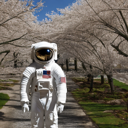

an astronaut standing on a engaging white rose, in the midst of by ivory cherry blossoms
----------------------------------------


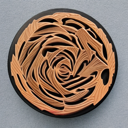

ramen carved out of fractal rose ebony, in the style of hudson river school
----------------------------------------


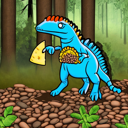

ultrasaurus holding a black bean taco in the woods, near an identical cheneosaurus
----------------------------------------

— COCO Examples —


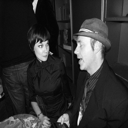

A couple of hipster emo people sitting down together.
----------------------------------------


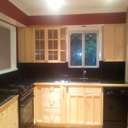

An empty kitchen has new cabinets and counters.
----------------------------------------


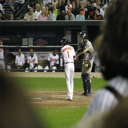

a baseball player is getting ready to hit the ball
----------------------------------------

— F30k Examples —


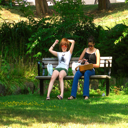

 Two women on a bench .
----------------------------------------


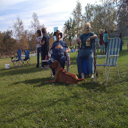

 An elderly man and woman are sitting on lawn chairs holding onto the leash of a brown dog .
----------------------------------------


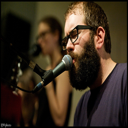

 A bearded singer with black rimmed glasses singing into a microphone .
----------------------------------------


In [2]:
root = Path(r"C:\Users\steph\OneDrive\Desktop\Springboard\Springboard\Capstone\step2\data")

# load the three annotation files

# Stable Diffusion CSV

sd_csv = root / "stable_diffusion" / "prompts.csv"
df_sd  = pd.read_csv(sd_csv)  

# COCO

coco_json = root / "coco" / "annotations" / "captions_train2017.json"
with open(coco_json, "r", encoding="utf-8") as f:
    coco = json.load(f)
    
#coco is a dictionary

#convert coco to dataframe and selects only two columns from the full annotations dataframe

df_coco = pd.DataFrame(coco["annotations"])[["image_id","caption"]]

# Flickr-30k
f30_csv = root / "flickr30k" / "results.csv"
df_f30  = pd.read_csv(f30_csv, sep="|")

"""
comments:

the data is messy here since there is stuff like '|' to separate fields

sep = '|' tells pandas the file is pipe-delimited rather than comma-separated like a CSV file

got to clean up some data, strip stray spaces from header
"""


df_f30.columns = [c.strip() for c in df_f30.columns]

"""
.strip() method since we have spaces so " example, hi  " -> "example, hi" 

removes all whitespace characters (spaces, tabs, newlines) from the beginning and end of a string.

it does not remove spaces within the text, just around it

"""


df_f30 = df_f30.rename(columns={"image_name":"image_id","comment":"caption"})

"""
rename to align with others "image_name" -> "image_id", "comment" -> "caption"
 
registry of (name, dataframe, image_folder, extension). 

list of tuples for a shorter name, dataframe, image directory, and file extension

"""

datasets = [
    ("SD",   df_sd,  root/"stable_diffusion"/"images",    ".png"),
    ("COCO", df_coco,root/"coco"/"train2017",             ".jpg"),
    ("F30k", df_f30, root/"flickr30k"/"flickr30k_images", ".jpg"),
]


"""
next we want to iterate over the datasets (name, dataframe, image directory, file extension)

the logic is the same for any of the 3 datasets, but let's pick one.

if the name is SD (stable diffusion), then we extract the image_id and caption from that row

so that we can append and build the image filename. We do this for all different kinds of datasets.

we sample 3 images from each of the 3 datasets.
"""

for name, df, img_dir, ext in datasets:
    print(f"\n— {name} Examples —")
    for row in df.sample(3, random_state=40).itertuples():
        # pick out id & text to build filename
        if name == "SD":
            img_id, caption = row.imgId,    row.prompt
            fname           = f"{img_id}.png"
        elif name == "COCO":
            img_id, caption = row.image_id, row.caption
            # zero-pad to 12 digits
            fname           = f"{int(img_id):012d}.jpg"
        else:  # Flickr30k
            img_id, caption = row.image_id, row.caption
            fname           = img_id

        path = img_dir / fname
    #we build the images in this path for each dataset here, and resets when we go to the next df


        img = Image.open(path).resize((128,128))
        display(img)
        print(caption)
        print("-"*40)


<a id="quality-checks"></a>
# 3. Quality Checks


In this section, we ensure that all three datasets (Stable Diffusion, COCO, Flickr30k):

- Use a consistent schema (`image_id`, `caption`)
- Have no missing or null captions
- Contain no duplicate entries


In [3]:
# Print out original column names for each dataset

print("SD columns:   ", df_sd.columns.tolist())
print("COCO columns: ", df_coco.columns.tolist())
print("F30k columns: ", df_f30.columns.tolist(), "\n")

# Rename them to a common schema: image_id & caption like before
df_sd = df_sd.rename(columns={
    "imgId":     "image_id",
    "prompt":    "caption"
})

df_coco = df_coco.rename(columns={
    "image_id":  "image_id",
    "caption":   "caption"
})

df_f30 = df_f30.rename(columns={
    "image_name":"image_id",
    "comment":   "caption"
})

# Report before cleanup
print("Before cleanup:")
print(f" SD missing captions: {df_sd['caption'].isna().sum():,} | SD dup IDs:  {df_sd['image_id'].duplicated().sum():,}")
print(f" COCO missing captions: {df_coco['caption'].isna().sum():,} | COCO dup rows: {df_coco.duplicated().sum():,}")
print(f" F30k missing captions: {df_f30['caption'].isna().sum():,} | F30k dup rows: {df_f30.duplicated().sum():,}\n")

# Cleanup. Drop rows with missing captions and remove duplicates
df_sd   = df_sd.dropna(subset=["caption"]).drop_duplicates(subset=["image_id","caption"]).reset_index(drop=True)
df_coco = df_coco.dropna(subset=["caption"]).drop_duplicates().reset_index(drop=True)
df_f30  = df_f30.dropna(subset=["caption"]).drop_duplicates().reset_index(drop=True)
#we need to reset the index back to 0 since we dropped dups and NaNs

# Report after cleanup. A final check to confirm that no nulls or duplicates remain in any of the datasets
print("After cleanup:")
print(f" SD missing captions: {df_sd['caption'].isna().sum():,} | SD dup IDs:  {df_sd['image_id'].duplicated().sum():,}")
print(f" COCO missing captions: {df_coco['caption'].isna().sum():,} | COCO dup rows: {df_coco.duplicated().sum():,}")
print(f" F30k missing captions: {df_f30['caption'].isna().sum():,} | F30k dup rows: {df_f30.duplicated().sum():,}")

#I also noticed that if we don't have the ":" after the sum then we would have the tuple (0, ). ":" fixes it
#It is just formatting, we don't actually need this, but it looks nicer


SD columns:    ['imgId', 'prompt']
COCO columns:  ['image_id', 'caption']
F30k columns:  ['image_id', 'comment_number', 'caption'] 

Before cleanup:
 SD missing captions: 0 | SD dup IDs:  0
 COCO missing captions: 0 | COCO dup rows: 142
 F30k missing captions: 1 | F30k dup rows: 0

After cleanup:
 SD missing captions: 0 | SD dup IDs:  0
 COCO missing captions: 0 | COCO dup rows: 0
 F30k missing captions: 0 | F30k dup rows: 0


<a id="descriptive-statistics"></a>
# 4. Descriptive Statistics

In this section, we compute basic statistics on the **caption lengths** (i.e., number of words or tokens) for each dataset:

- Stable Diffusion (SD)
- COCO Captions
- Flickr30k

This helps us understand how verbose or concise prompts/captions tend to be across datasets.

In [4]:
"""
Helper function: count tokens (words) in each string of a Pandas Series
.str.split() splits each string into a list of words. Here's an example:

s = pd.Series(['hi there', 'hello world!', 'test'])
s.str.split().str.len()
which outputs

0    2   # ['hi', 'there']
1    2   # ['hello', 'world!']
2    1   # ['test']

s.str.split().str.len()

gives: [2, 2, 1] the number of words per string. Effectively gives us a word count for every caption

Note that: 

If we only had .str.len() the number of characters in each string, including spaces and punctuation:

0     8
1    12
2     4

.str.len() counts how many tokens are in each list

"""

def token_counts(series):
    return series.str.split().str.len()

# Stable Diffusion (previously 'prompt', now stored under 'caption')
df_sd["caption_len"]  = token_counts(df_sd["caption"])

# COCO Captions
df_coco["caption_len"] = token_counts(df_coco["caption"])

# Flickr-30k Captions
df_f30["caption_len"]  = token_counts(df_f30["caption"])

# Print summary statistics for each dataset
print("Stable Diffusion caption lengths:")
print(df_sd["caption_len"].describe(), "\n")

print("COCO    caption lengths:")
print(df_coco["caption_len"].describe(), "\n")

print("Flickr-30k caption lengths:")
print(df_f30["caption_len"].describe())


Stable Diffusion caption lengths:
count     7.000000
mean     14.428571
std       4.314979
min       9.000000
25%      13.000000
50%      13.000000
75%      15.000000
max      23.000000
Name: caption_len, dtype: float64 

COCO    caption lengths:
count    591611.000000
mean         10.457432
std           2.392678
min           5.000000
25%           9.000000
50%          10.000000
75%          11.000000
max          49.000000
Name: caption_len, dtype: float64 

Flickr-30k caption lengths:
count    158914.000000
mean         13.389418
std           5.421043
min           2.000000
25%          10.000000
50%          12.000000
75%          16.000000
max          82.000000
Name: caption_len, dtype: float64


<a id="length-distribution"></a>
# 5. Length Distribution

In this section, we visualize the **distribution of caption lengths (in number of tokens)** across all three datasets.

This helps us answer:
- Are prompts/captions generally short or long?
- Do Stable Diffusion prompts use more words than human-written captions?
- Are there outliers or irregular length patterns?

We calculate the number of tokens per caption and plot histograms to compare the datasets side-by-side.


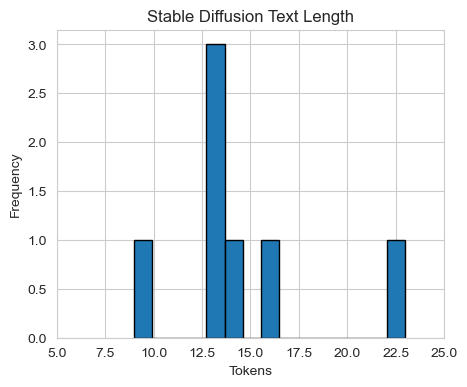

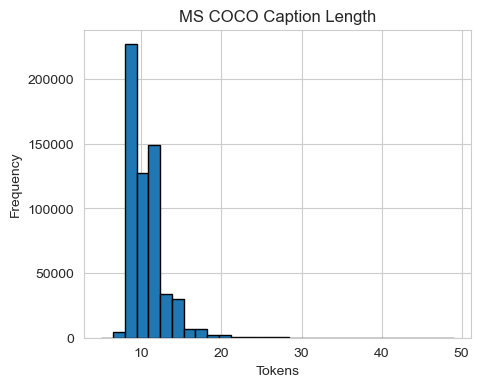

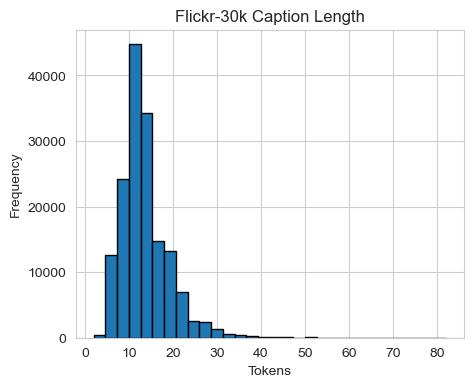

In [5]:
# Compute token lengths
for df in (df_sd, df_coco, df_f30):
    df["caption_len"] = df["caption"].str.split().str.len()

# Plot Stable Diffusion
plt.figure(figsize=(5, 4))
plt.hist(df_sd["caption_len"], bins=15, edgecolor="black")
plt.title("Stable Diffusion Text Length")
plt.xlim(5, 25)
plt.xlabel("Tokens")
plt.ylabel("Frequency")
plt.show()

# Plot COCO
plt.figure(figsize=(5, 4))
plt.hist(df_coco["caption_len"], bins=30, edgecolor="black")
plt.title("MS COCO Caption Length")
plt.xlabel("Tokens")
plt.ylabel("Frequency")
plt.show()

# Plot Flickr-30k
plt.figure(figsize=(5, 4))
plt.hist(df_f30["caption_len"], bins=30, edgecolor="black")
plt.title("Flickr-30k Caption Length")
plt.xlabel("Tokens")
plt.ylabel("Frequency")
plt.show()



<a id="token-frequency"></a>
# 6. Token Frequency

In this section, we identify and visualize the **Top 20 most frequently used tokens (words)** in each dataset.

This helps us understand:
- What kinds of words are most common in each captioning style
- Whether Stable Diffusion prompts use different vocabulary compared to human-written captions

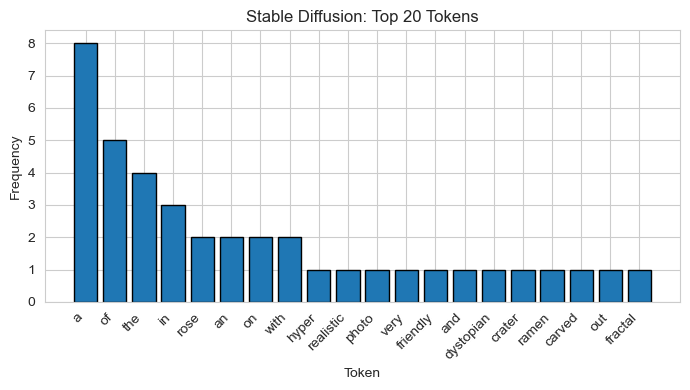

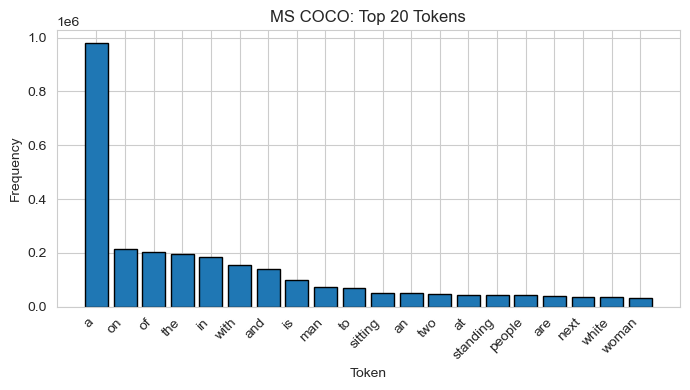

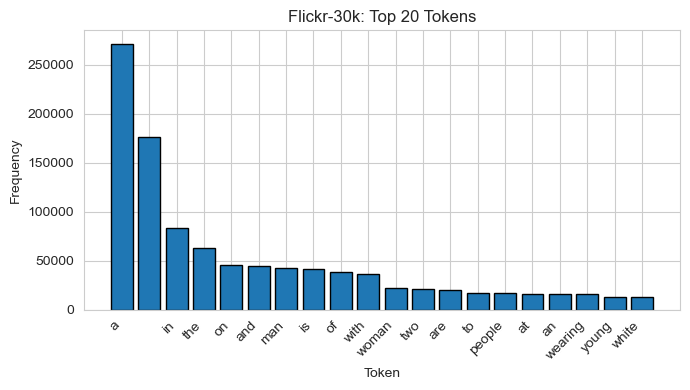

In [6]:
def plot_top_tokens(texts, title, n=20):
    tokens = Counter(
        t.lower().strip(".,!?-") # Normalize by lowercasing and stripping punctuation
        for txt in texts
        for t in txt.split() # Tokenize each caption into words
    )
    tf = pd.DataFrame(tokens.most_common(n), columns=["token","count"])

    plt.figure(figsize=(7,4))
    plt.bar(tf["token"], tf["count"], edgecolor="black")
    plt.xticks(rotation=45, ha="right")
    plt.title(title)
    plt.xlabel("Token")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

plot_top_tokens(df_sd["caption"],   "Stable Diffusion: Top 20 Tokens")
plot_top_tokens(df_coco["caption"], "MS COCO: Top 20 Tokens")
plot_top_tokens(df_f30["caption"],  "Flickr-30k: Top 20 Tokens")


<a id="feature-engineering-correlations"></a>
# 7. Feature Engineering & Correlations

In this section, we:
1. Load and standardize captions from all three datasets.
2. Engineer useful features like character count, digit count, punctuation count, and token diversity.
3. Compute and visualize correlations between these features.

The goal is to uncover how structural properties of the text (e.g., length, uniqueness, use of punctuation) relate to each other in prompts vs. captions.


Data folders: ['coco', 'flickr30k', 'stable_diffusion']


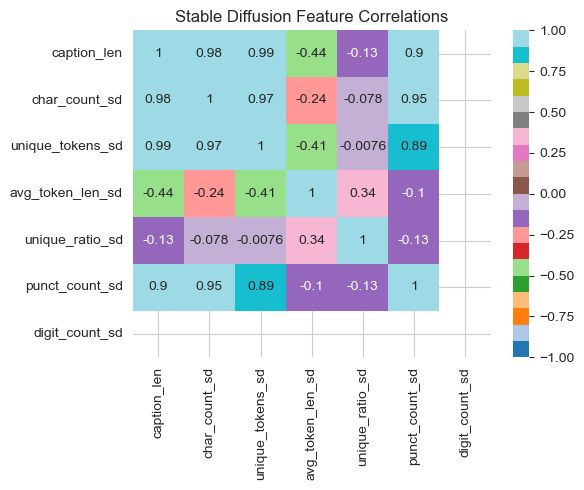

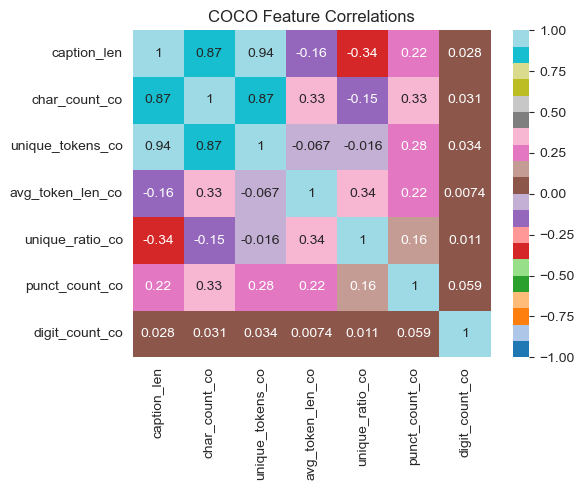

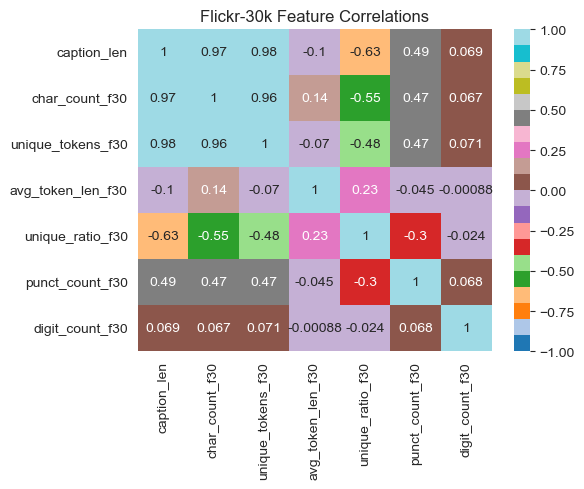

In [7]:
root = Path(r"C:\Users\steph\OneDrive\Desktop\Springboard\Springboard\Capstone\step2\data")
print("Data folders:", [p.name for p in root.iterdir() if p.is_dir()])

# Stable Diffusion
sd_csv = root/"stable_diffusion"/"prompts.csv"
df_sd  = pd.read_csv(sd_csv).rename(columns={'prompt':'caption'})

# MS COCO
coco_json = root/"coco"/"annotations"/"captions_train2017.json"
with open(coco_json, "r", encoding="utf-8") as f:
    anns = json.load(f)["annotations"]
df_coco = pd.DataFrame(anns)[["image_id","caption"]]

# Flickr-30k
f30_csv = root/"flickr30k"/"results.csv"
df_f30  = pd.read_csv(f30_csv, sep="|")
df_f30.columns = [c.strip() for c in df_f30.columns]
df_f30 = df_f30.rename(columns={"image_name":"image_id","comment":"caption"})

# Ensure no NaNs break our feature code
for df in (df_sd, df_coco, df_f30):
    df['caption'] = df['caption'].fillna('').astype(str)
    df['caption_len'] = df['caption'].str.split().str.len()

# Feature engineering
for df, prefix in [(df_sd,'sd'), (df_coco,'co'), (df_f30,'f30')]:
    df[f'char_count_{prefix}']   = df['caption'].str.len()
    df[f'unique_tokens_{prefix}'] = df['caption'].str.split().apply(lambda ws: len(set(ws)))
    df[f'punct_count_{prefix}']  = df['caption'].str.count(r'[^\w\s]')
    df[f'digit_count_{prefix}']  = df['caption'].str.count(r'\d')
    df[f'avg_token_len_{prefix}'] = df[f'char_count_{prefix}'] / df['caption_len'].replace(0,1)
    df[f'unique_ratio_{prefix}'] = df[f'unique_tokens_{prefix}'] / df['caption_len'].replace(0,1)

# Correlation matrices
cols_sd = ['caption_len','char_count_sd','unique_tokens_sd','avg_token_len_sd','unique_ratio_sd','punct_count_sd','digit_count_sd']
cols_co = ['caption_len','char_count_co','unique_tokens_co','avg_token_len_co','unique_ratio_co','punct_count_co','digit_count_co']
cols_f30= ['caption_len','char_count_f30','unique_tokens_f30','avg_token_len_f30','unique_ratio_f30','punct_count_f30','digit_count_f30']

corr_sd  = df_sd[cols_sd].corr()
corr_co  = df_coco[cols_co].corr()
corr_f30 = df_f30[cols_f30].corr()

# Plot heatmaps
for corr, title in [
    (corr_sd,  "Stable Diffusion Feature Correlations"),
    (corr_co,  "COCO Feature Correlations"),
    (corr_f30, "Flickr-30k Feature Correlations")
]:
    plt.figure(figsize=(6,5))
    sns.heatmap(corr, annot=True, vmin=-1, vmax=1, cmap="tab20")
    plt.title(title)
    plt.tight_layout()
    plt.show()


<a id="extremes-shortest-longest-promptscaptions"></a>
# 8. Extremes: Shortest & Longest Prompts/Captions

In this section, we inspect the **3 shortest** and **3 longest** prompts or captions in each dataset based on their token counts (`caption_len`).

This is a helpful sanity check to:
- Verify correct token length calculations
- Explore edge cases in text style and structure


In [8]:
# Stable Diffusion shortest & longest prompts
print("SD shortest:\n",
      df_sd.nsmallest(3, "caption_len")[["imgId", "caption_len", "caption"]],
      "\n")
print("SD longest:\n",
      df_sd.nlargest(3,  "caption_len")[["imgId", "caption_len", "caption"]],
      "\n")

# COCO shortest & longest captions
print("COCO shortest:\n",
      df_coco.nsmallest(3, "caption_len")[["image_id", "caption_len", "caption"]],
      "\n")
print("COCO longest:\n",
      df_coco.nlargest(3,  "caption_len")[["image_id", "caption_len", "caption"]],
      "\n")

# Flickr-30k shortest & longest captions
print("F30k shortest:\n",
      df_f30.nsmallest(3, "caption_len")[["image_id", "caption_len", "caption"]],
      "\n")
print("F30k longest:\n",
      df_f30.nlargest(3,  "caption_len")[["image_id", "caption_len", "caption"]])



SD shortest:
        imgId  caption_len  \
0  20057f34d            9   
2  92e911621           13   
3  a4e1c55a9           13   

                                                                              caption  
0                         hyper realistic photo of very friendly and dystopian crater  
2  ultrasaurus holding a black bean taco in the woods, near an identical cheneosaurus  
3       a thundering retro robot crane inks on parchment with a droopy french bulldog   

SD longest:
        imgId  caption_len  \
6  f27825b2c           23   
5  d8edf2e40           16   
1  227ef0887           14   

                                                                                               caption  
6  Kaggle employee Phil at a donut shop ordering all the best donuts, with a speech bubble that pro...  
5             an astronaut standing on a engaging white rose, in the midst of by ivory cherry blossoms  
1                          ramen carved out of fractal rose ebony, in 

<a id="image-file-size-distribution"></a>
# 9. Image File-Size Distribution

In this section, we examine the **distribution of file sizes** across images in the Stable Diffusion, COCO, and Flickr-30k datasets.

This helps us:
- Check for unusually large or small files (e.g., corrupted images or inconsistent formats)
- Verify that files are accessible and formatted properly

Checking Stable Diffusion folder: exists=True
Checking MS COCO         folder: exists=True
Checking Flickr-30k      folder: exists=True
Stable Diffusion: found 7/7 files
MS COCO        : found 591753/591753 files
Flickr-30k     : found 158915/158915 files


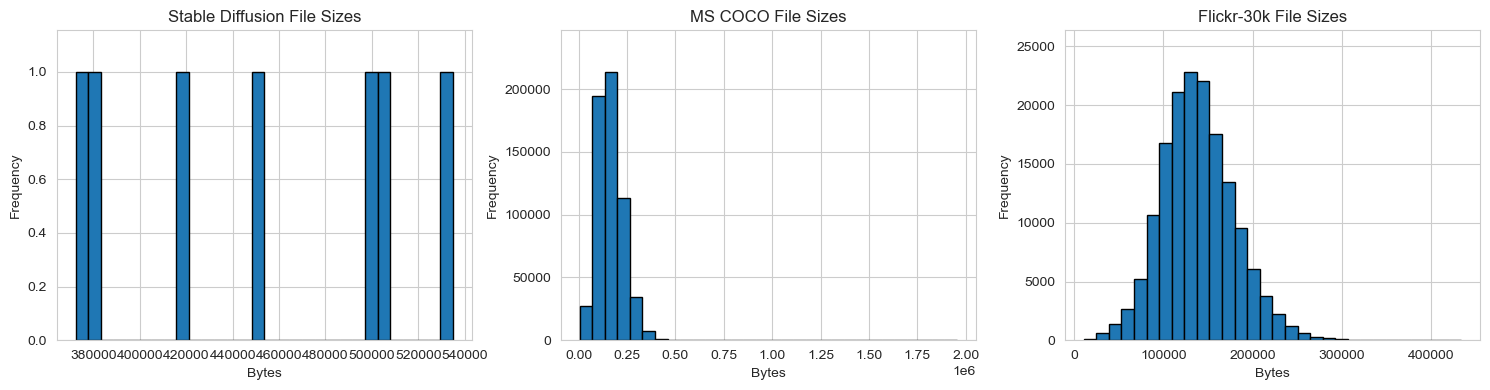

In [9]:
datasets = [
    ("Stable Diffusion", df_sd,  root/"stable_diffusion"/"images",      [".png", ".jpg"]),
    ("MS COCO",          df_coco,root/"coco"/"train2017",              [".jpg"]),
    ("Flickr-30k",       df_f30,  root/"flickr30k"/"flickr30k_images", [".jpg"]),
]

# Confirms whether the image folder exists. Prepares to track file sizes and count found images
all_info = {}
for name, df, img_dir, exts in datasets:
    print(f"Checking {name:15} folder: exists={img_dir.exists()}")
    sizes = []; found = 0
    id_col = "imgId" if name=="Stable Diffusion" else "image_id"

    for img_id in df[id_col]:
        base = f"{int(img_id):012d}" if name=="MS COCO" else img_id
        for ext in exts:
            if base.lower().endswith(ext):
                fname = base
            else:
                fname = f"{base}{ext}"
            p = img_dir/fname
            if p.exists():
                sizes.append(p.stat().st_size)
                found += 1
                break

    all_info[name] = {"sizes":sizes,"found":found,"total":len(df)}

# report
for name,info in all_info.items():
    print(f"{name:15}: found {info['found']}/{info['total']} files")

# plot 
fig, axes = plt.subplots(1, 3, figsize=(15,4), sharey=False)
for ax, (name, info) in zip(axes, all_info.items()):
    ax.hist(info["sizes"], bins=30, edgecolor="black")
    ax.set_title(f"{name} File Sizes")
    ax.set_xlabel("Bytes")
    ax.set_ylabel("Frequency")
    ytop = ax.get_ylim()[1]
    ax.set_ylim(0, ytop*1.1)

plt.tight_layout()
plt.show()



<a id="word-cloud-of-prompts"></a>
# 10. Word Cloud of Prompts

In this section, we generate **word clouds** to get a high-level visual overview of the most frequent tokens used in each dataset.

This is useful to:
- Quickly spot dominant words and themes
- Visually compare vocabulary usage across Stable Diffusion prompts, MS COCO captions, and Flickr-30k captions


Notebook cwd: C:\Users\steph\OneDrive\Desktop
Data root: C:\Users\steph\OneDrive\Desktop\Springboard\Springboard\Capstone\step2\data
Subfolders: ['coco', 'flickr30k', 'stable_diffusion']


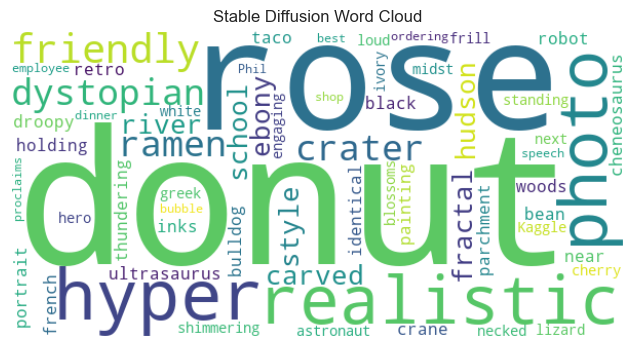

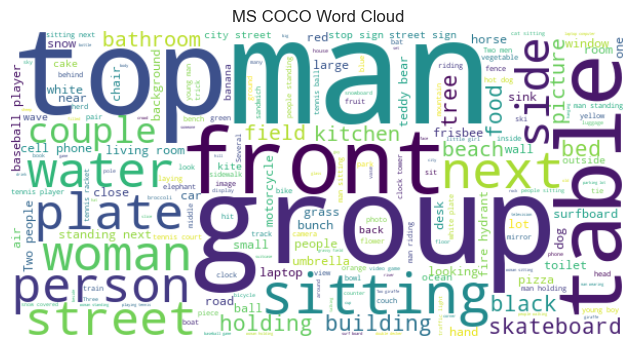

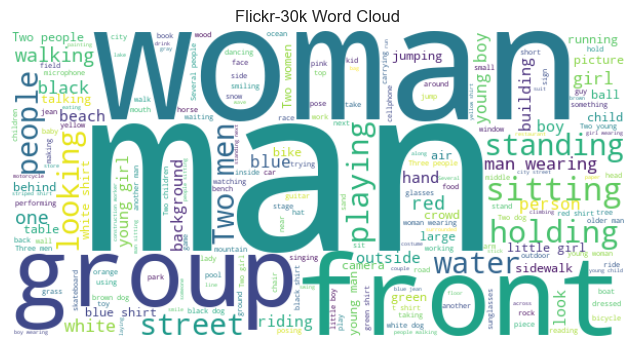

In [10]:
# Show where we are and what’s in data/
print("Notebook cwd:", os.getcwd())
root = Path(r"C:\Users\steph\OneDrive\Desktop\Springboard\Springboard\Capstone\step2\data")
print("Data root:", root)
print("Subfolders:", [p.name for p in root.iterdir() if p.is_dir()])

# Define annotation paths and check they exist
sd_csv   = root/"stable_diffusion"/"prompts.csv"
coco_json= root/"coco"/"annotations"/"captions_train2017.json"
f30_csv  = root/"flickr30k"/"results.csv"

assert sd_csv.exists(),    f"Can't find SD CSV at {sd_csv}"
assert coco_json.exists(), f"Can't find COCO JSON at {coco_json}"
assert f30_csv.exists(),   f"Can't find F30k CSV at {f30_csv}"

# Load the data
df_sd   = pd.read_csv(sd_csv)  
with open(coco_json, "r", encoding="utf-8") as f:
    coco_ann = json.load(f)["annotations"]
df_coco = pd.DataFrame(coco_ann)[["image_id","caption"]]
df_f30  = pd.read_csv(f30_csv, sep="|")
df_f30.columns = [c.strip() for c in df_f30.columns]
df_f30 = df_f30.rename(columns={"image_name":"image_id","comment":"caption"})

# Generate + show word clouds
for title, texts in [
    ("Stable Diffusion", df_sd["prompt"]),
    ("MS COCO",          df_coco["caption"]),
    ("Flickr-30k",       df_f30["caption"])
]:
    blob = " ".join(texts.dropna().astype(str))
    wc = WordCloud(width=600, height=300, background_color="white").generate(blob)
    plt.figure(figsize=(8,4))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"{title} Word Cloud")
    plt.show()


<a id="cross-dataset-comparison"></a>
# 11. Cross-Dataset Comparison

In this section, we summarize and compare key metrics across all three datasets:

- Total number of captions
- Unique number of images
- Average number of captions per image
- Average token (word) length
- Vocabulary size

This helps us understand dataset scale, caption redundancy, prompt complexity, and language diversity.

In [11]:
# 0) Absolute paths
data_root = Path(r"C:\Users\steph\OneDrive\Desktop\Springboard\Springboard\Capstone\step2\data")

# 1) Define paths
sd_csv     = data_root/"stable_diffusion"/"prompts.csv"
coco_json  = data_root/"coco"/"annotations"/"captions_train2017.json"
f30_csv    = data_root/"flickr30k"/"results.csv"

# 2) Load data
df_sd = pd.read_csv(sd_csv)
with open(coco_json, "r", encoding="utf-8") as f:
    coco_ann = json.load(f)["annotations"]
df_coco = pd.DataFrame(coco_ann)[["image_id","caption"]]
df_f30 = pd.read_csv(f30_csv, sep="|")
df_f30.columns = [c.strip() for c in df_f30.columns]
df_f30 = df_f30.rename(columns={"image_name":"image_id","comment":"caption"})

# 3) Build summary
summary = {}

df_sd['length'] = df_sd['prompt'].str.split().str.len()
summary['Stable Diffusion'] = {
    'total_rows': df_sd.shape[0],
    'unique_images': df_sd['imgId'].nunique(),
    'avg_captions_per_image': 1.0,
    'avg_token_length': df_sd['length'].mean(),
    'vocab_size': len({
        t.lower().strip(".,!?-")
        for p in df_sd['prompt'].dropna().astype(str)
        for t in p.split()
    })
}

df_coco['length'] = df_coco['caption'].str.split().str.len()
summary['MS COCO'] = {
    'total_rows': df_coco.shape[0],
    'unique_images': df_coco['image_id'].nunique(),
    'avg_captions_per_image': df_coco.groupby('image_id').size().mean(),
    'avg_token_length': df_coco['length'].mean(),
    'vocab_size': len({
        t.lower().strip(".,!?-")
        for p in df_coco['caption'].dropna().astype(str)
        for t in p.split()
    })
}

df_f30['length'] = df_f30['caption'].str.split().str.len()
summary['Flickr-30k'] = {
    'total_rows': df_f30.shape[0],
    'unique_images': df_f30['image_id'].nunique(),
    'avg_captions_per_image': df_f30.groupby('image_id').size().mean(),
    'avg_token_length': df_f30['length'].mean(),
    'vocab_size': len({
        t.lower().strip(".,!?-")
        for p in df_f30['caption'].dropna().astype(str)
        for t in p.split()
    })
}

# 4) Display
comp = pd.DataFrame(summary).T[[
    'total_rows','unique_images','avg_captions_per_image','avg_token_length','vocab_size'
]]
display(comp)


,total_rows,unique_images,avg_captions_per_image,avg_token_length,vocab_size
Stable Diffusion,7.0,7.0,1.000000,14.428571,81.0
MS COCO,591753.0,118287.0,5.002688,10.457179,31854.0
Flickr-30k,158915.0,31783.0,5.000000,13.389418,20276.0


<a id="zipfs-law"></a>
# 12. Zipf’s Law

In this section, we examine whether the word distributions in each dataset follow [**Zipf’s Law**](https://en.wikipedia.org/wiki/Zipf%27s_law), which is a well-documented empirical law in quantitative linguistics.

Zipf’s Law states that the frequency $$ f $$ of a word is inversely proportional to its rank $$ r $$ in the frequency table:


$$ 
f(r) \propto \frac{1}{r^s}
$$


The exponent $$ s $$ is typically close to 1. Taking logarithms, the law implies a linear relationship:

$$
\log f = -s \log r + \text{constant}
$$


---

## This analysis is useful to:

- Validate the linguistic structure of each dataset  
- Compare language patterns between AI-generated prompts (Stable Diffusion) and human-written captions (COCO, Flickr-30k)
- Confirm Zipfian behavior by estimating the slope $$ s $$ via linear regression in log-log space

---

## What to expect:

- A strong Zipfian pattern (straight line in log-log plot) if the dataset reflects natural language use.
- A slope $$ s \approx 1 $$ for datasets like COCO and Flickr-30k.
- Potential deviation in slope or fit for AI-generated prompts depending on their diversity and structure.

We’ll plot frequency vs. rank for each dataset and fit a line to assess how well they conform to Zipf’s Law.


Stable Diffusion  slope = -0.77  R² = 0.928
MS COCO          slope = -1.18  R² = 0.977
Flickr-30k       slope = -1.17  R² = 0.996


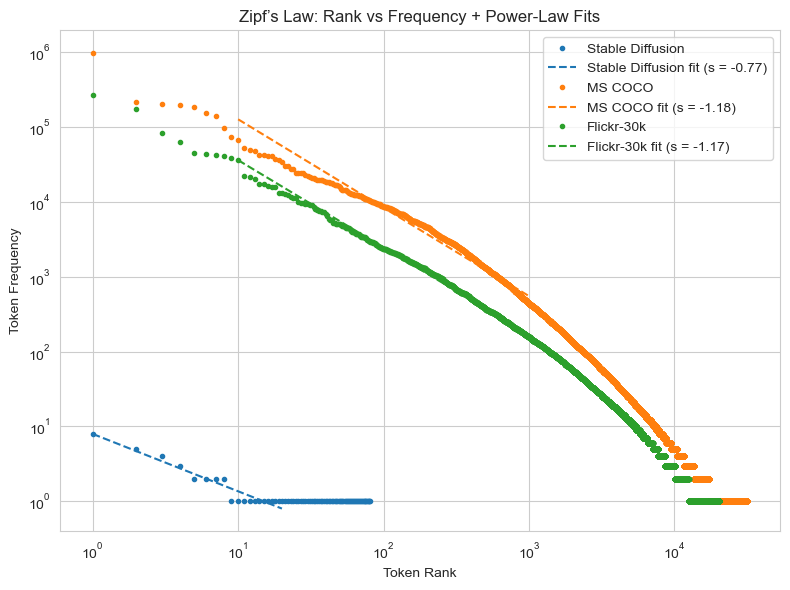

In [12]:

root = Path(r"C:\Users\steph\OneDrive\Desktop\Springboard\Springboard\Capstone\step2\data")

# load three annotation files 
df_sd = pd.read_csv(root/"stable_diffusion"/"prompts.csv")
with open(root/"coco"/"annotations"/"captions_train2017.json","r",encoding="utf8") as f:
    coco_data = json.load(f)["annotations"]
df_coco = pd.DataFrame(coco_data)[["image_id","caption"]]
df_f30 = pd.read_csv(
    root/"flickr30k"/"results.csv",
    sep="|"
)
df_f30.columns = [c.strip() for c in df_f30.columns]
df_f30 = df_f30.rename(columns={"image_name":"image_id","comment":"caption"})

# build token-frequency tables
def make_rank_freq(texts):
    toks = (t.lower().strip(".,!?;:-")
            for txt in texts.dropna() for t in txt.split())
    freq = pd.Series(list(toks)).value_counts()
    return pd.DataFrame({
        "rank": np.arange(1, len(freq)+1),
        "freq": freq.values
    })

sd_rf  = make_rank_freq(df_sd["prompt"])
co_rf  = make_rank_freq(df_coco["caption"])
f30_rf = make_rank_freq(df_f30["caption"])

# plot + power-law fits with data‐driven windows 
plt.figure(figsize=(8,6))
ax = plt.gca()

for name, rf, color, fit_window in [
    ("Stable Diffusion", sd_rf,   "C0", (1, 20)),
    ("MS COCO",          co_rf,   "C1", (10,1000)),
    ("Flickr-30k",       f30_rf,  "C2", (10,1000)),
]:
    x = rf["rank"].values
    y = rf["freq"].values
    ax.loglog(x, y, ".", color=color, label=name)
    
    lo, hi = fit_window
    mask = (x>=lo)&(x<=hi)
    if mask.sum()>=3:
        logx = np.log10(x[mask]); logy = np.log10(y[mask])
        m,b = np.polyfit(logx, logy, 1)
        # R²:
        ypred = m*logx + b
        ss_res = ((logy-ypred)**2).sum()
        ss_tot = ((logy-logy.mean())**2).sum()
        r2 = 1 - ss_res/ss_tot
        
        print(f"{name:15}  slope = {m:.2f}  R² = {r2:.3f}")
        
        fx = np.logspace(np.log10(lo), np.log10(hi), 100)
        fy = 10**(b + m*np.log10(fx))
        ax.loglog(fx, fy, "--", color=color,
                  label=f"{name} fit (s = {m:.2f})")
    else:
        print(f"{name:15}  not enough data in ranks [{lo},{hi}] to fit")

ax.set_xlabel("Token Rank")
ax.set_ylabel("Token Frequency")
ax.set_title("Zipf’s Law: Rank vs Frequency + Power-Law Fits")
ax.legend()
plt.tight_layout()
plt.show()




### Observations

We can see that we are getting the correct behavior: the plotted data follows a clear linear pattern in log-log space for COCO and Flickr-30k. This confirms that these datasets obey Zipf’s Law.